In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random
import tensorflow as tf

In [2]:
### Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print('Available Physical GPUs=>'+str(gpus))
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print('Configured Logical GPUs=>'+str(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Available Physical GPUs=>[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Configured Logical GPUs=>[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [3]:
class VPP(Env):
    def __init__(self):
        #Environment parameters
        self.state = random.randint(0, 100)  #current soc
        self.max_soc = 95
        self.min_soc = 15
        self.generation = random.randint(0, 100)
        self.demand = random.randint(5, 75)
        self.gd_diff = self.generation - self.demand

        #Action space (charge, discharge, isolate)
        self.action_space = Discrete(3)

        #State_space
        self.observation_space = Box(low = np.array([0]), high = np.array([100]))

        #Set episode length
        self.episode_length = 900


    #Define steps based on action
    def step(self, action):
        if action == 0:    #charge
            self.state = self.state+1
        elif action == 1:   #discharge
            self.state = self.state-1
        # Action 2 : Isolate (no effect on SoC)

        self.episode_length -= 1

    
        #Define the reward based on generation, demand, and current soc level
        if (self.gd_diff > 0) & self.state>=self.min_soc & self.state<=self.max_soc:
            reward = 1.0
        else:
            reward = -1.0

        #Check if the episode is done
        if self.episode_length<=0:
            done = True
        else:
            done = False

        info = {}

        return self.state, reward, done, info
    
    def render(self):
        pass

    def reset(self):
        self.state = random.randint(0, 100)
        self.episode_length = 900
        return self.state

In [4]:
env = VPP()

c:\Users\Arbil\anaconda3\envs\py37gpu\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [5]:
#Random action in each step
print(env.action_space.sample())

#dimention of state
print(env.observation_space.shape[0])

#Random initial temp
print(env.state)

2
1
73


In [6]:
action = env.action_space.sample()
state, reward, done, info = env.step(action)
print(state, reward, done, info)

73 -1.0 False {}


In [7]:
ep = []
scr = []
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        score += reward
    ep.append(int(episode))
    scr.append(score)
    print('Episode:{} Score:{}'.format(episode, score))

Episode:1 Score:-748.0
Episode:2 Score:-682.0
Episode:3 Score:-758.0
Episode:4 Score:-798.0
Episode:5 Score:-762.0
Episode:6 Score:-846.0
Episode:7 Score:-712.0
Episode:8 Score:-768.0
Episode:9 Score:-828.0
Episode:10 Score:-732.0


Text(0, 0.5, 'Score')

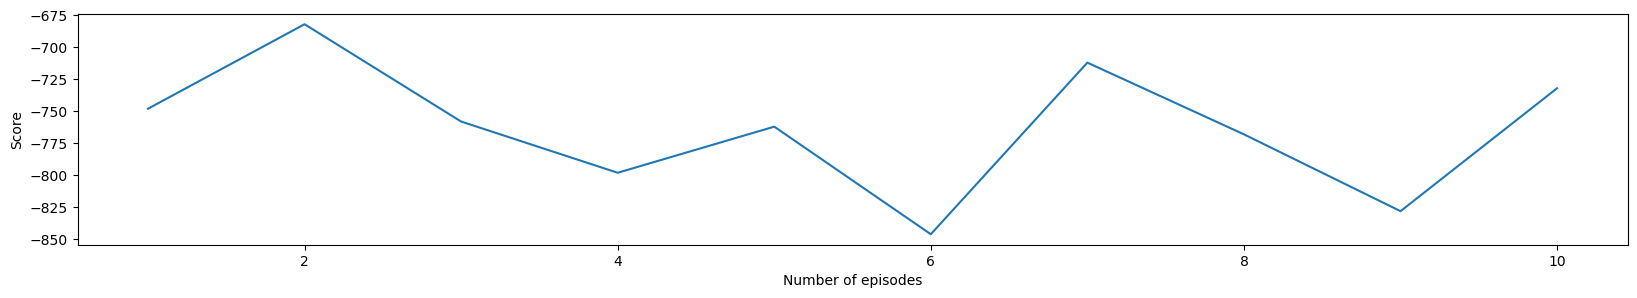

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,3))

plt.plot(ep, scr)
plt.xlabel('Number of episodes')
plt.ylabel('Score')

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [10]:
states = env.observation_space.shape
actions = env.action_space.n

In [11]:
print(states, actions)

(1,) 3


In [12]:
def build_model(states,actions):
    model = Sequential()
    model.add(Dense(24, activation = 'relu', input_shape = states))
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(actions, activation = 'linear'))
    return model

In [17]:
del model

In [18]:
model = build_model(states, actions)

In [19]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [15]:
def  build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit = 50000, window_length = 1)
    ddqn = DQNAgent(model = model, memory = memory, policy = policy,
                   nb_actions = actions, nb_steps_warmup = 10, target_model_update = 1e-2,
                   enable_double_dqn= True)
    return ddqn

In [20]:
ddqn = build_agent(model, actions)
ddqn.compile(Adam(lr = 1e-3), metrics = ['mae'])
ddqn.fit(env, nb_steps = 50000, visualize = False,  verbose = 1)

Training for 50000 steps ...
Interval 1 (0 steps performed)


c:\Users\Arbil\anaconda3\envs\py37gpu\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


    1/10000 [..............................] - ETA: 2:24:29 - reward: -1.0000

c:\Users\Arbil\anaconda3\envs\py37gpu\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 78s 8ms/step - reward: -0.8710
11 episodes - episode_reward: -783.273 [-840.000, -728.000] - loss: 0.517 - mae: 10.674 - mean_q: 2.095

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: -0.8268
11 episodes - episode_reward: -744.545 [-830.000, -650.000] - loss: 1.454 - mae: 26.675 - mean_q: -39.461

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 77s 8ms/step - reward: -0.7762
11 episodes - episode_reward: -701.818 [-790.000, -570.000] - loss: 1.964 - mae: 35.853 - mean_q: -53.221

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 78s 8ms/step - reward: -0.6200
11 episodes - episode_reward: -571.636 [-808.000, -466.000] - loss: 1.765 - mae: 35.909 - mean_q: -53.156

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 81s 8ms/step - reward: -0.4242
done, took 390.661 seconds


In [22]:
scores = ddqn.test(env, nb_episodes = 100, visualize = False)
print(np.mean(scores.history['episode_reward']))

Testing for 100 episodes ...
Episode 1: reward: 870.000, steps: 900
Episode 2: reward: 822.000, steps: 900
Episode 3: reward: 854.000, steps: 900
Episode 4: reward: 808.000, steps: 900
Episode 5: reward: 732.000, steps: 900
Episode 6: reward: 744.000, steps: 900
Episode 7: reward: 720.000, steps: 900
Episode 8: reward: 864.000, steps: 900
Episode 9: reward: 726.000, steps: 900
Episode 10: reward: 870.000, steps: 900
Episode 11: reward: 796.000, steps: 900
Episode 12: reward: 726.000, steps: 900
Episode 13: reward: 762.000, steps: 900
Episode 14: reward: 784.000, steps: 900
Episode 15: reward: 776.000, steps: 900
Episode 16: reward: 752.000, steps: 900
Episode 17: reward: 812.000, steps: 900
Episode 18: reward: 852.000, steps: 900
Episode 19: reward: 860.000, steps: 900
Episode 20: reward: 830.000, steps: 900
Episode 21: reward: 770.000, steps: 900
Episode 22: reward: 872.000, steps: 900
Episode 23: reward: 892.000, steps: 900
Episode 24: reward: 742.000, steps: 900
Episode 25: reward: 

Text(0, 0.5, 'Reward')

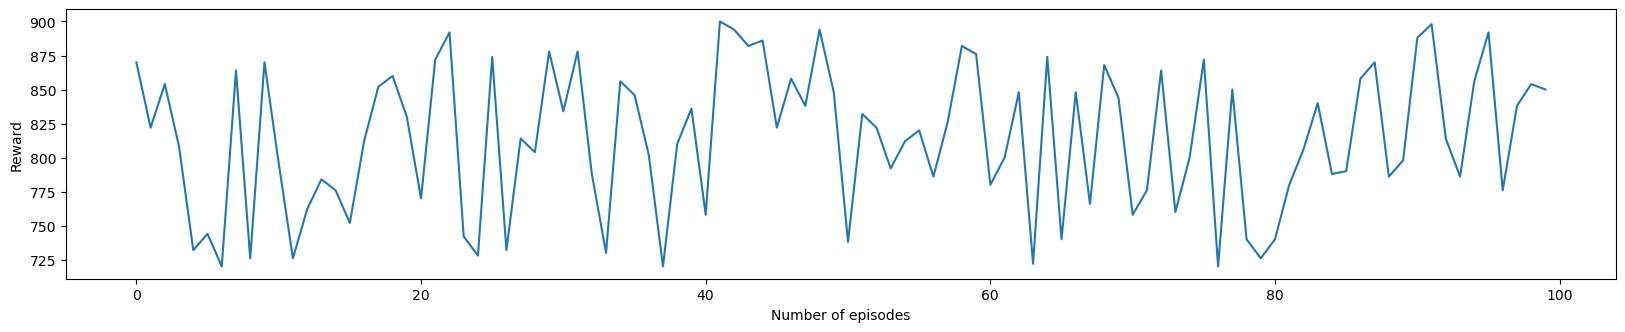

In [23]:
plt.figure(figsize = (20,3.5))
plt.plot(scores.history['episode_reward'])
plt.xlabel('Number of episodes')
plt.ylabel('Reward')

In [28]:
score_array = scores.history['episode_reward']
mean_score = np.mean(score_array)
print(mean_score)

813.96
